Not a cleanest notebook, more for archiving purposes.

In [1]:
from fastai.vision.all import *
from utils import (
    generic_image_path,
    generic_image_path_processed,
    generic_segmentation_path,
    generic_segmentation_path_processed,
    paste_imgs,
)

In [2]:
def add_mask(source: Image.Image, mask: Image.Image) -> Image.Image:
    source = source.convert('RGBA')
    # mask = Image.fromarray(np.r_[mask] * 255).convert('RGBA')
    mask = mask.convert('RGBA')
    M = np.r_[mask]
    M[:, :, 1:2] = 0
    M[:, :, 3] = 120
    
    mask = Image.fromarray(M)
    return Image.alpha_composite(source, mask)

In [ ]:
root = Path("..")

In [ ]:
df = pd.read_csv("metadata.csv")

In [5]:
image_path = generic_image_path(root)
image_path_processed = generic_image_path_processed(root)
segmentation_path = generic_segmentation_path(root)
segmentation_path_processed = generic_segmentation_path_processed(root)

In [ ]:
image_paths = df.filename.apply(image_path_processed).apply(Path)

In [9]:
def label_func(p:Path):
    return segmentation_path_processed(p.name)

In [10]:
df['segmentation_file_processed'] = df.filename.apply(segmentation_path_processed)
df['image_file_processed'] = df.filename.apply(image_path_processed)

### Training

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=["nothing", "lipid_sac"])),
    get_x=ColReader("image_file_processed"),
    get_y=ColReader("segmentation_file_processed"),
    splitter=ColSplitter("is_valid"),
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(pad_mode='zeros', max_rotate=180, max_zoom = 2, )]
).dataloaders(df, batch_size=4)

/opt/conda/envs/fa/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/opt/conda/envs/fa/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlg

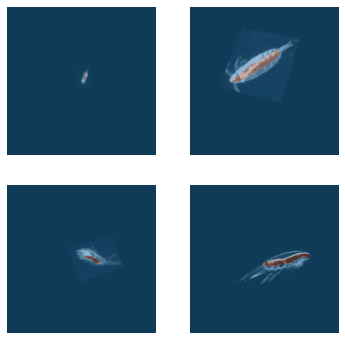

In [12]:
dls.show_batch()

In [21]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [16]:
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [22]:
combined_loss = CombinedLoss()

In [23]:
learn = unet_learner(dls, resnet34, loss_func=combined_loss, metrics=[IoU])

/opt/conda/envs/fa/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
cbs = []
cbs.append(EarlyStoppingCallback(patience=5))
cbs.append(SaveModelCallback(fname="model_resnet34"))
cbs.append(GradientAccumulation(n_acc=8))

In [25]:
learn = unet_learner(dls, resnet34)

learn.fine_tune(40, cbs=cbs)

epoch,train_loss,valid_loss,time
0,0.044853,0.028264,09:11


Better model found at epoch 0 with valid_loss value: 0.0282643660902977.


epoch,train_loss,valid_loss,time
0,0.024093,0.019321,09:25
1,0.021899,0.015389,09:26
2,0.018776,0.014430,09:25
3,0.016554,0.013459,09:26
4,0.016678,0.012319,09:24
5,0.014889,0.014045,09:23
6,0.014661,0.011477,09:23
7,0.014260,0.012811,09:21
8,0.013845,0.011835,09:20
9,0.018271,0.020270,09:18


Better model found at epoch 0 with valid_loss value: 0.019320696592330933.
Better model found at epoch 1 with valid_loss value: 0.015389186330139637.
Better model found at epoch 2 with valid_loss value: 0.014429899863898754.
Better model found at epoch 3 with valid_loss value: 0.01345917023718357.
Better model found at epoch 4 with valid_loss value: 0.012319426983594894.
Better model found at epoch 6 with valid_loss value: 0.01147699449211359.
Better model found at epoch 10 with valid_loss value: 0.010551639832556248.
Better model found at epoch 14 with valid_loss value: 0.010385076515376568.
Better model found at epoch 15 with valid_loss value: 0.01022674422711134.
Better model found at epoch 17 with valid_loss value: 0.009923617355525494.
Better model found at epoch 19 with valid_loss value: 0.009909604676067829.
Better model found at epoch 21 with valid_loss value: 0.009645333513617516.
Better model found at epoch 25 with valid_loss value: 0.009228114038705826.
Better model found at

In [27]:
learn.export("models/learner.pkl")

In [20]:
learn.save("model_backup")

Path('models/model_backup.pth')

### Validation

In [28]:
learn2 = load_learner("models/learner.pkl", cpu=False)

In [29]:
learn2.load("model_resnet34_after26")

/opt/conda/envs/fa/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [30]:
dls2 = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=["nothing", "lipid_sac"])),
    get_x=ColReader("image_file_processed"),
    get_y=ColReader("segmentation_file_processed"),
    splitter=ColSplitter("is_valid"),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
).dataloaders(df, batch_size=4)

/opt/conda/envs/fa/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [31]:
res = learn2.get_preds(dl=dls2[1], reorder=False, with_input=True)

/opt/conda/envs/fa/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
